https://stackoverflow.com/questions/60481471/trying-to-interpolate-the-output-of-a-histogram-function-in-python

In [1]:
import os
from pathlib import Path
from ROOT import TFile, TMath, TF1, gROOT, TCanvas, TGraph, TGraphErrors, TH1F

Welcome to JupyROOT 6.26/06


In [2]:
def getall(d, basepath="/"):
    "Generator function to recurse into a ROOT file/dir and yield (path, obj) pairs"
    for key in d.GetListOfKeys():
        kname = key.GetName()
        if key.IsFolder():
            # TODO: -> "yield from" in Py3
            for i in getall(d.Get(kname), basepath+kname+"/"):
                yield i
        else:
            yield d.Get(kname)

In [4]:
folder_out=os.path.join(
    os.path.dirname(os.getcwd()),
    "04_ML_classification"
)
path_root = Path(folder_out)
files=[root_file.as_posix() for root_file in path_root.glob('**/*.root')]

ttbar_b_tau_tau_hadronic


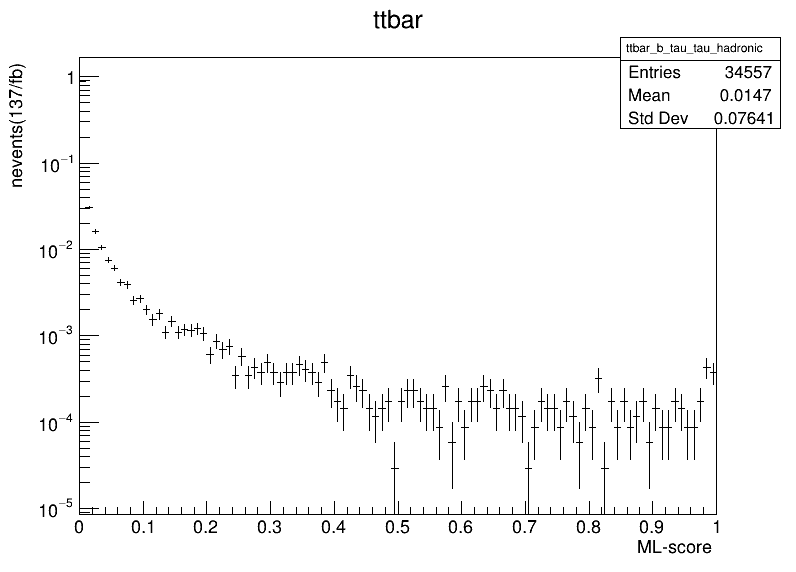

In [5]:
c1=TCanvas("","",800,600)
c1.SetLogy()
a=1
x=[0]
y=[0]
err_y=[0]
for file in files:
    f=TFile(file)
    for h in getall(f):
        if (h.GetName()!="ttbar_b_tau_tau_hadronic"): continue
        h.Scale(1.0/h.Integral())
        h.Draw()
        print(h.GetName())
        sum_=0.
        erry=0.0
        dx=1./h.GetNbinsX()
        for i in range (h.GetNbinsX()):
            if h.GetBinContent(i+1) !=0 :
                x.append((i+1)*(1./h.GetNbinsX()))
                sum_+=h.GetBinContent(i+1)
                erry+=h.GetBinError(i+1)
                y.append(sum_)
                err_y.append(erry)
        break
    break
if x[len(x)-1]<1 :
    x.append(1.)
    y.append(1.)
    err_y.append(err_y[len(err_y)-1])

err_x=[dx/2 for i in x]
c1.Draw()

In [6]:
import numpy as np
from scipy.interpolate import PchipInterpolator
x=np.array(x)
y=np.array(y)

err_x=np.array(err_x)
err_y=np.array(err_y)

y_sup=y+err_y
y_inf=y-err_y

y_sup=y_sup/max(y_sup)
y_inf=y_inf/max(y_inf)

interp_func_mid=PchipInterpolator(x, y)
interp_func_sup=PchipInterpolator(x, y_sup)
interp_func_inf=PchipInterpolator(x, y_inf)

step=1e-5
new_x = np.log(np.arange(1., np.exp(1), step)+step)
new_y_sup = interp_func_sup(new_x)
new_y_inf = interp_func_inf(new_x)

"""
n=1
Y=[]
X=[]

for num in new_x:
    a=interp_func_sup(num)
    b=interp_func_inf(num)
    s=np.random.normal(abs(a+b)/2., abs(a-b)/4.,n)
    for int_ in s:
        Y.append(int_)
        X.append(num) 
Y=np.array(Y)
X=np.array(X)
"""
X=new_x
Y=interp_func_mid(new_x)
Y

array([0.00131039, 0.00262072, 0.00393096, ..., 0.99999987, 1.        ,
       1.00000012])

In [7]:
import numpy as np
from scipy import signal as sig
from matplotlib import pyplot as plt
import seaborn as sns
from __future__ import division, print_function

In [8]:
def butter_filtfilt( x, Wn=0.5, axis=0 ):
    """ butter( 2, Wn ), filtfilt
        axis 0 each col, -1 each row
    """
    b, a = sig.butter( N=2, Wn=Wn )
    return sig.filtfilt( b, a, x, axis=axis, method="gust" )  # twice, forward backward

In [9]:
def ints( x ):
    return x.round().astype(int)

In [10]:
def minavmax( x ):
    return "min av max %.3g %.3g %.3g" % (
        x.min(), 
        x.mean(), 
        x.max() 
    )

In [11]:
def pvec( x ):
    n = len(x) // 25 * 25
    return "%s \n%s \n" % (
        minavmax( x ),
        ints( x[ - n : ]) .reshape( -1, 25 ))

In [12]:
#...............................................................................
def monofit( a, Wn=1e-4):
    y=a
    y=np.log(a)
    """ monotone-increasing curve fit """
    y = np.asarray(y).squeeze()
    
    ygrad = np.gradient( y )

    # lowpass filter --
    gradsmooth = butter_filtfilt( ygrad, Wn=Wn )

    ge0 = np.fmax( gradsmooth, 0 )

    ymono = np.cumsum( ge0 )  # integrate, sensitive to first few
    ymono += (y - ymono).mean()

    err = y - ymono
    errstr = "average |y - monofit|: %.2g" % np.abs( err*100 ).mean()
    ymono=np.exp(ymono)
    return ymono, err, errstr

In [13]:
Wn=step*110
ymono, err, errstr = monofit( Y , Wn )
errstr

'average |y - monofit|: 0.85'

In [14]:
Y=ymono/max(ymono)

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


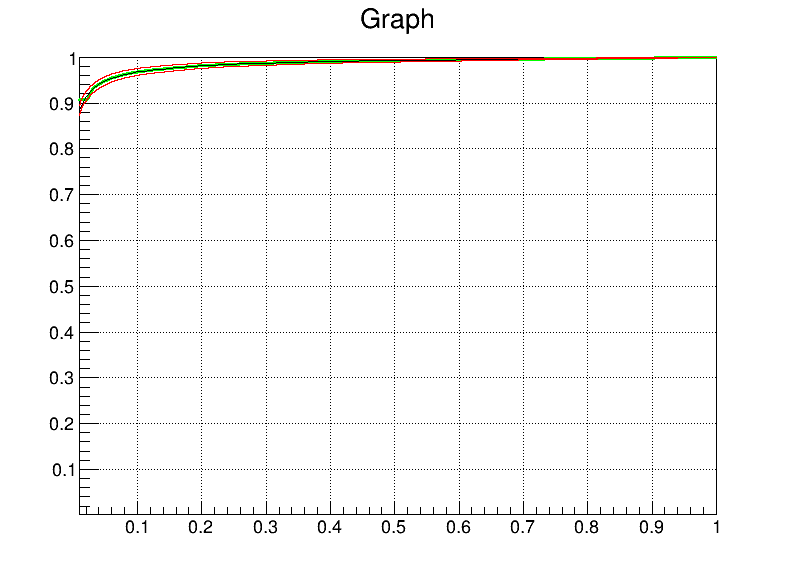

In [16]:
c1=TCanvas("c1","",800,600)
#c1.SetLogx()
#c1.SetLogy()
c1.SetGrid()

g=TGraphErrors(len(x),x,y)#,err_x,err_y)
g.SetLineWidth(1)
#g.SetMaximum(1.1)
g.SetMarkerStyle(1)
g.SetMarkerColor(2)

g2=TGraph(len(new_x),new_x,new_y_sup)
g2.SetLineColor(2)

g3=TGraph(len(new_x),new_x,new_y_inf)
g3.SetLineColor(2)

g4=TGraph(len(X),X,Y)
g4.SetLineColor(3)
g4.SetLineWidth(3)

g4.SetMinimum(1e-3)
g4.SetMaximum(1)
g4.GetXaxis().SetRangeUser(0.01,1)
g4.Draw("al")
g.Draw("l")

g2.Draw("l")
g3.Draw("l")

c1.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


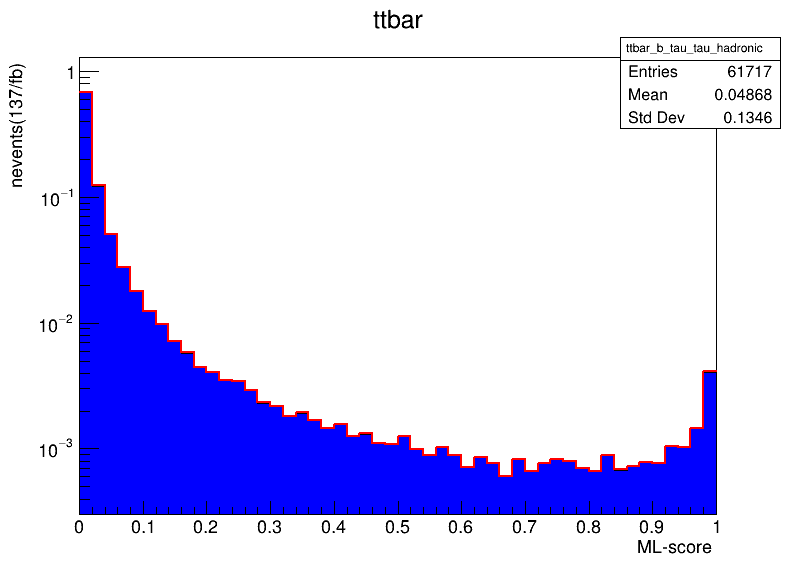

In [15]:
c1=TCanvas("c1","",800,600)
c1.SetLogy()
from scipy import interpolate
tck = interpolate.splrep(X, Y, s=0)
step=step/10
xnew = np.log(np.arange(1., np.exp(1), step)+step)
ynew = interpolate.splev(xnew, tck, der=0)

interp_func = PchipInterpolator(xnew, ynew)
n_bins=50
hist_test=TH1F("test","test",n_bins,0.,1.)

for bin_ in range(hist_test.GetNbinsX()):
    hist_test.SetBinContent(bin_+1,interp_func((bin_+1)/n_bins)-interp_func((bin_)/n_bins))
    
h.Scale(1./h.Integral())
h.Draw("HIST")
h.Rebin(int(h.GetNbinsX()/n_bins))
#h.SetMinimum(5e-4)

hist_test.Scale(1/hist_test.Integral())

hist_test.SetLineColor(2)
hist_test.SetLineWidth(2)
hist_test.DrawNormalized("HISTsame")

c1.Draw()